In [70]:
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [71]:
X, y= make_classification(n_samples= 10000, n_features= 4, return_X_y= True, n_classes= 2, random_state= 42)
scaler= StandardScaler()
X= scaler.fit_transform(X)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42)

In [72]:
class MyDataset(nn.Module):
    def __init__(self, X, y, device):
        self.device= device
        self.targets= torch.tensor(y, dtype= torch.float32, device= device)
        self.features= torch.tensor(X, dtype= torch.float32, device= device)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [73]:
device= torch.device('cuda' if torch.cuda.is_available else 'cpu')
batch_size= 32
train_dataset= MyDataset(X_train, y_train, device)
test_dataset= MyDataset(X_test, y_test, device= device)

train_loader= DataLoader(dataset= train_dataset, batch_size= batch_size, shuffle= True)
test_loader= DataLoader(dataset= test_dataset, batch_size= batch_size, shuffle= False)

## Manual Backpropagation: Mathematical Derivation

### Network Architecture
This 2-layer MLP performs the following forward pass:
- **Layer 1:** $z_1 = x \cdot W_1 + b_1$, $a_1 = \sigma(z_1)$
- **Layer 2:** $z_2 = a_1 \cdot W_2 + b_2$
- **Output:** $\hat{y} = z_2$ (logits)

Where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid activation function.

### Loss Function
We use **BCEWithLogitsLoss** which combines sigmoid activation with binary cross-entropy:

$$L = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\sigma(z_{2i})) + (1-y_i) \log(1-\sigma(z_{2i})) \right]$$

### Backward Pass Derivation

#### Step 1: Output Layer Gradient
For BCEWithLogitsLoss, the gradient with respect to logits is:
$$\frac{\partial L}{\partial z_2} = \sigma(z_2) - y_{true} = p - y_{true}$$

#### Step 2: Second Layer Parameter Gradients
Using chain rule:
$$\frac{\partial L}{\partial W_2} = a_1^T \cdot \frac{\partial L}{\partial z_2}$$
$$\frac{\partial L}{\partial b_2} = \sum_{batch} \frac{\partial L}{\partial z_2}$$

#### Step 3: First Hidden Layer Gradient
Backpropagating through the second layer:
$$\frac{\partial L}{\partial a_1} = \frac{\partial L}{\partial z_2} \cdot W_2^T$$

#### Step 4: First Layer Pre-activation Gradient
Applying sigmoid derivative $\sigma'(z) = \sigma(z)(1-\sigma(z))$:
$$\frac{\partial L}{\partial z_1} = \frac{\partial L}{\partial a_1} \odot \frac{\partial a_1}{\partial z_1} = \frac{\partial L}{\partial a_1} \odot a_1 \odot (1-a_1)$$

#### Step 5: First Layer Parameter Gradients
$$\frac{\partial L}{\partial W_1} = x^T \cdot \frac{\partial L}{\partial z_1}$$
$$\frac{\partial L}{\partial b_1} = \sum_{batch} \frac{\partial L}{\partial z_1}$$

#### Step 6: Parameter Updates
Using gradient descent:
$$W_1 \leftarrow W_1 - \alpha \frac{\partial L}{\partial W_1}$$
$$b_1 \leftarrow b_1 - \alpha \frac{\partial L}{\partial b_1}$$
$$W_2 \leftarrow W_2 - \alpha \frac{\partial L}{\partial W_2}$$
$$b_2 \leftarrow b_2 - \alpha \frac{\partial L}{\partial b_2}$$

Where $\alpha$ is the learning rate and $\odot$ denotes element-wise multiplication.

In [74]:
class TinyMLP(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()

        self.hidden_size= hidden_size
        
        # Initializing weights and biases
        self.w1= torch.randn(input_size, hidden_size, requires_grad= False, dtype= torch.float32, device= device)
        self.b1= torch.zeros(hidden_size, requires_grad= False, dtype= torch.float32, device= device)
        self.w2= torch.randn(hidden_size, 1, requires_grad= False, dtype= torch.float32, device= device)
        self.b2= torch.zeros(1, requires_grad= False, dtype= torch.float32, device= device)

        # Initialize gradient storage
        self.dL_dw1 = torch.zeros_like(self.w1)
        self.dL_db1 = torch.zeros_like(self.b1)
        self.dL_dw2 = torch.zeros_like(self.w2)
        self.dL_db2 = torch.zeros_like(self.b2)

        # For gradient comparison
        self.w1_autograd= self.w1.clone().requires_grad_(True)
        self.b1_autograd= self.b1.clone().requires_grad_(True)
        self.w2_autograd= self.w2.clone().requires_grad_(True)
        self.b2_autograd= self.b2.clone().requires_grad_(True)
    
    def reset_gradients(self):
        self.dL_dw1.fill_(0)
        self.dL_db1.fill_(0)
        self.dL_dw2.fill_(0)
        self.dL_db2.fill_(0)
        
    def forward(self, x): 
        # Manual forward pass
        z1= x @ self.w1 + self.b1
        a1= torch.sigmoid(z1)
        self.a1= a1
        z2= a1 @ self.w2 + self.b2
        a2= torch.sigmoid(z2)

        return z2
    
    def forward_autograd(self, x):
        # Autograd Fwd pass
        z1= x @ self.w1_autograd + self.b1_autograd
        a1= torch.sigmoid(z1)
        z2= a1 @ self.w2_autograd + self.b2_autograd
        a2= torch.sigmoid(z2)
        return z2

    def manual_backward(self, x, y_hat, y_true, learning_rate= 0.01):
        # Reset gradients at start of backward pass
        
        batch_size = x.size(0)
        p = torch.sigmoid(y_hat)
        
        # For BCEWithLogitsLoss, dL/dz2 = sigmoid(z2) - y_true
        dL_dz2 = (p - y_true) / batch_size  # Average over batch
        
        # Gradients for second layer
        self.dL_dw2 = self.a1.T @ dL_dz2
        self.dL_db2 = torch.sum(dL_dz2, dim=0)
        
        # Backprop through first layer
        dL_da1 = dL_dz2 @ self.w2.T
        da1_dz1 = self.a1 * (1 - self.a1)  # sigmoid derivative
        dL_dz1 = dL_da1 * da1_dz1
        
        # Gradients for first layer
        self.dL_dw1 = x.T @ dL_dz1
        self.dL_db1 = torch.sum(dL_dz1, dim=0)
        
        # Update weights manually
        with torch.no_grad():
            self.w1 -= learning_rate * self.dL_dw1
            self.b1 -= learning_rate * self.dL_db1
            self.w2 -= learning_rate * self.dL_dw2
            self.b2 -= learning_rate * self.dL_db2

        self.reset_gradients()
    def autograd_backward(self, y_pred, y_true, loss_fn, learning_rate= 0.01):

        # Compute loss
        loss= loss_fn(y_pred, y_true)
        # Backward pass with autograd
        loss.backward()

        
        # Update weights using autograd
        with torch.no_grad():
            
            self.w1_autograd-= learning_rate * self.w1_autograd.grad
            self.b1_autograd-= learning_rate * self.b1_autograd.grad
            self.w2_autograd-= learning_rate * self.w2_autograd.grad
            self.b2_autograd-= learning_rate * self.b2_autograd.grad
        
        # Zero gradients before updating
        self.w1_autograd.grad.zero_()
        self.b1_autograd.grad.zero_()
        self.w2_autograd.grad.zero_()
        self.b2_autograd.grad.zero_()


In [75]:
# Initializing model
num_epochs= 20

torch.manual_seed(42)
model= TinyMLP(input_size= 4, hidden_size= 1024, device= device)
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD([model.w1_autograd, model.b1_autograd, model.w2_autograd, model.b2_autograd], lr= 0.01)

train_loss_manual_history= []
train_loss_autograd_history= []
val_loss_history= []

epoch_train_manual_loss= 0.0
epoch_train_autograd_loss= 0.0

for epoch in range(num_epochs):
    # Train manual model
    model.train()
    epoch_train_manual_loss = 0.0
    for x_batch, y_batch in train_loader:
        # Forward pass
        y_pred_manual = model(x_batch)
        
        # Compute loss
        loss_manual = loss_fn(y_pred_manual, y_batch.unsqueeze(1))
        
        # Manual backward
        model.manual_backward(x_batch, y_pred_manual, y_batch.unsqueeze(1), learning_rate=0.01)
        
        epoch_train_manual_loss += loss_manual.item()
    
    epoch_train_manual_loss /= len(train_loader)
    train_loss_manual_history.append(epoch_train_manual_loss)
    
    # Train autograd model
    model.train()
    epoch_train_autograd_loss = 0.0
    for x_batch, y_batch in train_loader:
        # Forward pass
        y_pred_autograd = model.forward_autograd(x_batch)
        
        # Compute loss
        loss_autograd = loss_fn(y_pred_autograd, y_batch.unsqueeze(1))
        
        # Autograd backward
        model.autograd_backward(y_pred_autograd, y_batch.unsqueeze(1), loss_fn, learning_rate=0.01)
        
        epoch_train_autograd_loss += loss_autograd.item()
    
    epoch_train_autograd_loss /= len(train_loader)
    train_loss_autograd_history.append(epoch_train_autograd_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for x_val, y_val in test_loader:
            y_pred = model(x_val)
            val_loss += loss_fn(y_pred, y_val.unsqueeze(1)).item()
        val_loss /= len(test_loader)
    
    print(f"Epoch {epoch + 1}")
    val_loss_history.append(val_loss)

    with torch.no_grad():
        grad_diff = torch.norm(model.dL_dw1 - model.w1_autograd.grad) / (torch.norm(model.w1_autograd.grad) + 1e-4)
        print(f"Gradient relative error: {grad_diff.item():.5f}")
        
    print("-" * 10)
    print(f"Train Loss Manual Forward: {epoch_train_manual_loss:.5f}")
    print(f"Train Loss Autograd Forward: {epoch_train_autograd_loss:.5f}")
    print(f"Validation Loss: {val_loss:.5f}")
    print("-" * 50)

Epoch 1
Gradient relative error: 0.00000
----------
Train Loss Manual Forward: 0.78001
Train Loss Autograd Forward: 0.78765
Validation Loss: 0.26340
--------------------------------------------------
Epoch 2
Gradient relative error: 0.00000
----------
Train Loss Manual Forward: 0.26126
Train Loss Autograd Forward: 0.25987
Validation Loss: 0.25154
--------------------------------------------------
Epoch 3
Gradient relative error: 0.00000
----------
Train Loss Manual Forward: 0.25037
Train Loss Autograd Forward: 0.25101
Validation Loss: 0.24673
--------------------------------------------------
Epoch 4
Gradient relative error: 0.00000
----------
Train Loss Manual Forward: 0.24430
Train Loss Autograd Forward: 0.24402
Validation Loss: 0.24921
--------------------------------------------------
Epoch 5
Gradient relative error: 0.00000
----------
Train Loss Manual Forward: 0.23902
Train Loss Autograd Forward: 0.23838
Validation Loss: 0.23763
--------------------------------------------------


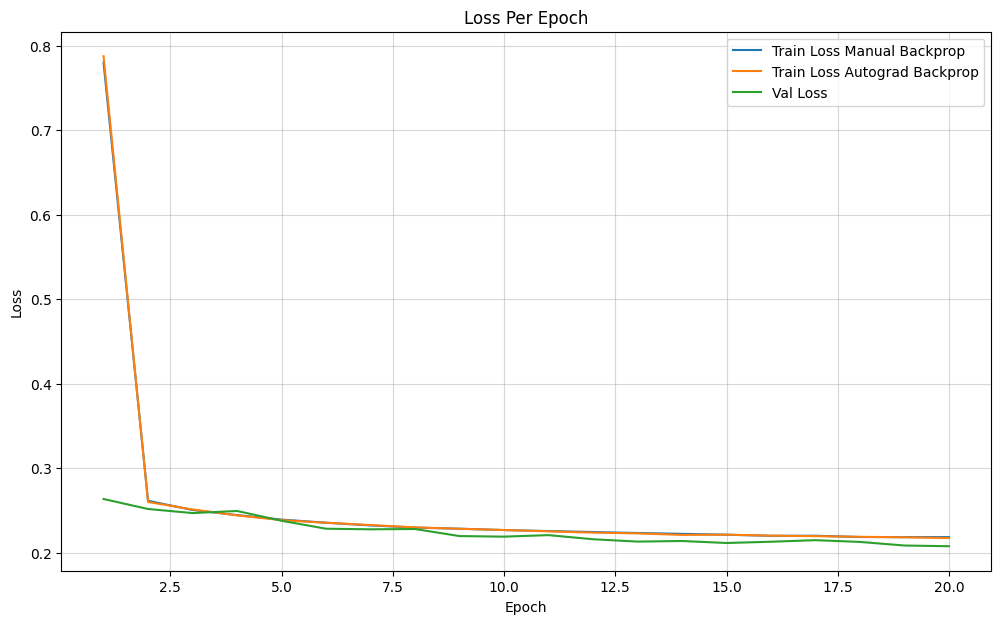

In [76]:
epochs= [epoch for epoch in range(1, num_epochs + 1)]
fig= plt.figure(figsize= (12, 7))
plt.title("Loss Per Epoch")
plt.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
p1= plt.plot(epochs, train_loss_manual_history)
p2= plt.plot(epochs, train_loss_autograd_history)
p3= plt.plot(epochs, val_loss_history)
plt.legend((p1[0], p2[0], p3[0]), ('Train Loss Manual Backprop', 'Train Loss Autograd Backprop', 'Val Loss'))